# Extra Assignment: Transformers and SSMs
Connor Blake, 5/23/25

In [20]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, processors
from sklearn.model_selection import train_test_split
import optax
from rdkit import Chem
from rdkit.Chem import Draw

Is this assignment too long? If you are using AI tools to the maximum extent, not at all. If the internet goes down? Yes.

## Problem 1: Transfomer
Explain, in as much detail as possible, how a Transformer works from the paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762). Be explicit in the use of function signatures, tensor dimensionalities, function definitions.

## Answer 1:



### 1 Notation and Shapes  

* B — batch size  
* T — source-sequence length  
* T′ — target-sequence length  
* H — number of attention heads  
* $d_{\text{model}}$ — model width  
* $d_k = d_{\text{model}} ⁄ H$ — key/query sub-dimension  
* $d_v = d_{\text{model}} ⁄ H$ — value sub-dimension  
* $d_{FF} ≈ 4 d_{\text{model}}$ — hidden width of the feed-forward layer  

Indices  

* b ∈ {0,…,B−1} — sequence in batch  
* t ∈ {0,…,T−1} — source token position  
* t′ ∈ {0,…,T′−1} — target token position  
* h ∈ {0,…,H−1} — head index  
* m ∈ {0,…,d_{\text{model}}−1} — model feature  
* i ∈ {0,…,d_k−1} — key/query feature  
* j ∈ {0,…,d_v−1} — value feature  
* r ∈ {0,…,$d_{\text{FF}}$}-1$ — feed-forward feature  

A tensor element $X_{b t m}$ contains feature $m$ of token $t$ in sequence $b$.

### 2 Primitive Operations  

#### 2.1 Softmax  

$$
\text{softmax}(Z)_{b n} = \frac{e^{Z_{b n}}}{\sum_{n′} e^{Z_{b n′}}}, \quad
Z \in \mathbb R^{B \times N}.
$$

#### 2.2 Layer Normalization  

Given $X_{b t m} ∈ ℝ^{B×T×d}  $

$$
\mu_{b t} = \frac{1}{d} \sum_{m} X_{b t m}, \qquad
\sigma_{b t} = \sqrt{\frac{1}{d} \sum_{m} (X_{b t m} - \mu_{b t})^{2} + \varepsilon},
$$
$$
\text{LayerNorm}(X)_{b t m} =
\frac{X_{b t m} - \mu_{b t}}{\sigma_{b t}} \, \gamma_{m} + \beta_{m},
$$

with learned gain $γ_{m}$ and bias $β_{m}$.

### 3 Scaled Dot-Product Attention  

#### 3.1 Linear projections  

Learn weight matrices  

* $W^{Q}_{m i} ∈ ℝ^{d_{\text{model}}×d_k}$  
* $W^{K}_{m i} ∈ ℝ^{d_{\text{model}}×d_k}  $
* $W^{V}_{m j} ∈ ℝ^{d_{\text{model}}×d_v}$

and form  

$$
Q_{b t i} = X_{b t m} \, W^{Q}_{m i}, \quad
K_{b t i} = X_{b t m} \, W^{K}_{m i}, \quad
V_{b t j} = X_{b t m} \, W^{V}_{m j}.
$$

Split the last index into H heads:  
$Q_{b t h i}, K_{b t h i} ∈ ℝ^{B×T×H×d_k}; V_{b t h j} ∈ ℝ^{B×T×H×d_v}$.

#### 3.2 Attention kernel and weights  

$$
S_{b h t_q t_k} = \frac{1}{\sqrt{d_k}}
\, Q_{b t_q h i} \, K_{b t_k h i}.
$$

For decoder self-attention, entries with $t_k > t_q$ are set to $-\infty$.

$$
\alpha_{b h t_q t_k} = \text{softmax}_{t_k} \bigl( S_{b h t_q t_k} \bigr).
$$

#### 3.3 Head output and combination  

$$
Z_{b t_q h j} = \alpha_{b h t_q t_k} \, V_{b t_k h j}.
$$

Concatenate heads as $Z_{b t n}$ with $n = h d_v + j$ and project

$$
\tilde Z_{b t m} = Z_{b t n} \, W^{O}_{n m},
\qquad W^{O} \in \mathbb R^{H d_v \times d_{\text{model}}}.
$$


### 4 Position-wise Feed-Forward Network  

$$
\tilde X_{b t r} = \max \bigl( 0, \, X_{b t m} W^{(1)}_{m r} + b^{(1)}_{r} \bigr),
$$
$$
Y_{b t m} = \tilde X_{b t r} \, W^{(2)}_{r m} + b^{(2)}_{m},
\qquad
W^{(1)} \in \mathbb R^{d_{\text{model}} \times d_{ff}},
\; W^{(2)} \in \mathbb R^{d_{ff} \times d_{\text{model}}}.
$$


### 5 Positional Encoding  

For position $t$ and feature $m$,

$$
\text{PE}_{t m} =
\begin{cases}
\sin \bigl( t / 10000^{\,2m / d_{\text{model}}} \bigr) & m \text{ even}, \\[6pt]
\cos \bigl( t / 10000^{\,2m / d_{\text{model}}} \bigr) & m \text{ odd}.
\end{cases}
$$

Add $PE_{t m}$ to token embeddings $E_{t m}$.

### 6 Encoder Layer  

With input $X^{(l)}_{b t m}$

1. Multi-head self-attention  
   $$ \hat Z_{b t m} = \text{MHA} \bigl( \text{LayerNorm}(X^{(l)}) \bigr)_{b t m}. $$
2. Residual add $Z_{b t m} = X^{(l)}_{b t m} + \hat Z_{b t m}$.  
3. Feed-forward  
   $$ \hat Y_{b t m} = \text{FFN} \bigl( \text{LayerNorm}(Z) \bigr)_{b t m}. $$
4. Residual add $X^{(l+1)}_{b t m} = Z_{b t m} + \hat Y_{b t m}$.

Repeat for $l = 0,…,L_E−1$; final output is memory $M_{b t m}$.


### 7 Decoder Layer  

With decoder input $Y^{(l)}_{b t′ m}$ and memory $M_{b t m}$

1. Masked self-attention  
   $$ \hat U = \text{MHA}_{\text{masked}} \bigl( \text{LayerNorm}(Y^{(l)}) \bigr). $$
2. $U = Y^{(l)} + \hat U$.  
3. Cross-attention  
   $$ \hat V = \text{MHA} \bigl( Q = \text{LayerNorm}(U),\, K = M,\, V = M \bigr). $$
4. $V = U + \hat V$.  
5. Feed-forward  
   $$ \hat Y = \text{FFN} \bigl( \text{LayerNorm}(V) \bigr). $$
6. $Y^{(l+1)} = V + \hat Y$.

Repeat for $l = 0,\ldots,L_D−1$.

### 8 End-to-End Forward Pass  

1. Encode the source to obtain memory $M_{b t m}$.  
2. Decode shifted-right targets with causal masking while attending to $M_{b t m}$.  
3. Project decoder states with $W^{\text{vocab}}_{m v}$ and apply softmax to obtain  
   $$ p(y_{t′} \mid y_{<t′}, x). $$


### 9 Training Objective  

$$
\mathcal L = -\sum_{b,\,t′} \log p \bigl( y_{t′}^{(b)} \mid y_{<t′}^{(b)},\, x^{(b)} \bigr),
$$

minimised with Adam using learning-rate warm-up and inverse-square-root decay.

### 10 Parameter and Complexity Summary  

| sub-unit | parameters | time per layer | space per layer |
|----------|------------|----------------|-----------------|
| multi-head attention | $3 d_{\text{model}} d_k H + d_{\text{model}} d_v H$ | $O(B T^{2} d_k)$ | $O(B T d_{\text{model}})$ |
| feed-forward | $2 d_{\text{model}} d_{\text{FF}}$ | $O(B T d_{\text{FF}})$ | $O(B T d_{\text{FF}})$ |
| layer norm | $2 d_{\text{model}}$ | negligible | negligible |



## Problem 2: ChemBERTa


This problem is based on the [ChemBERTa](https://arxiv.org/pdf/2010.09885) paper.
### a)
Load the file `250k_rndm_zinc_drugs_clean_3.csv` and set up a word-level tokenizer with a byte-level pre tokenizer. Explain what these mean and why they are needed.
### b)
Using this tokenizer, pick a nontrivial SMILES string. Print out the string, the tokenization, and use rdkit to display it.
### c)
Set up a train/test loader using BERT-style masking. Explain why there must be collation.
### d)
Set up and define a Transformer class, a Masked Transformer class, masking function and optimizers. Explain why a Masked Transformer is needed. Choose a loss function and justify it.
### e) 
Train the BERT-style model for a number of epochs until the loss is consistently less than ~3. Use the model to predict a previously-unseen SMILES string, and print out both the model, the masked, and the predicted. Qualitatively describe what's happening.

## Answer 2:

### a)

In [3]:
df_full = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')
df = df_full.iloc[:10000]
smiles = df['smiles'].tolist()

In [4]:
tokenizer = Tokenizer(models.WordLevel(unk_token='[UNK]'))
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
trainer = trainers.WordLevelTrainer(vocab_size=1000,
    special_tokens=['[PAD]','[UNK]','[CLS]','[SEP]','[MASK]'])
tokenizer.train_from_iterator(smiles, trainer=trainer)
tokenizer.post_processor = processors.TemplateProcessing(
    '[CLS] $A [SEP]', special_tokens=[('[CLS]',1),('[SEP]',2)])
tokenizer.enable_truncation(max_length=64)

Byte-level guarantees that every character is representable. Word-level allows the model to parse more complex strings like "Cl","=O" as a single item.

### b)

Cc1occc1C(=O)NC1CCN(C(=O)C(=O)Nc2ccc(F)cc2F)CC1

['[CLS]', 'ĠCc', '1', 'occc', '1', 'C', '(=', 'O', ')', 'NC', '1', 'CCN', '(', 'C', '(=', 'O', ')', 'C', '(=', 'O', ')', 'Nc', '2', 'ccc', '(', 'F', ')', 'cc', '2', 'F', ')', 'CC', '1', 'Ċ', '[SEP]']
[1, 32, 7, 216, 7, 6, 12, 10, 5, 29, 7, 52, 8, 6, 12, 10, 5, 6, 12, 10, 5, 35, 9, 18, 8, 26, 5, 17, 9, 26, 5, 23, 7, 13, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


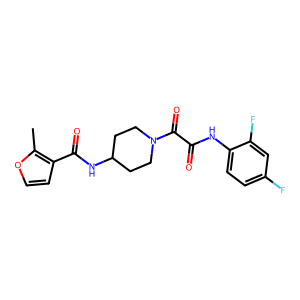

In [21]:
smiles0 = smiles[2100]
print(smiles0)
encoding0 = tokenizer.encode(smiles0)
print(encoding0.tokens)
print(encoding0.ids)
print(encoding0.attention_mask)
mol=Chem.MolFromSmiles(smiles0)
Draw.MolToImage(mol)

### c)

In [6]:
enc = {'input_ids':[], 'attention_mask':[]}
for e in tokenizer.encode_batch(smiles): # tokenizes each
    enc['input_ids'].append(e.ids)
    enc['attention_mask'].append(e.attention_mask)
ids = enc['input_ids']
masks = enc['attention_mask']
# train test split
ids_train, ids_test, masks_train, masks_test = train_test_split(
    ids, masks, test_size=0.1, random_state=42
)
# packs into dicts
train_enc = {'input_ids': ids_train, 'attention_mask': masks_train}
test_enc  = {'input_ids': ids_test,  'attention_mask': masks_test}

In [7]:
# dataset custom class
class SMILESDataset(Dataset):
    def __init__(self, enc):
        self.ids = enc['input_ids']
        self.mask = enc['attention_mask']
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.ids[i], dtype=torch.long),
            'attention_mask': torch.tensor(self.mask[i], dtype=torch.long)
        }

In [8]:
def collate_fn(batch):
    # this must exist to pad them all to the same length so they can be stacked and passed into transfomer
    ids = [item['input_ids'] for item in batch]
    masks = [item['attention_mask'] for item in batch]
    pad_id = tokenizer.token_to_id('[PAD]')
    ids_padded = pad_sequence(ids, batch_first=True, padding_value=pad_id)
    masks_padded = pad_sequence(masks, batch_first=True, padding_value=0)
    return {'input_ids': ids_padded, 'attention_mask': masks_padded}

Not all SMILES strings are the same length, so they must be padded to use standard uniform size tensor frameworks.

In [9]:
train_loader = DataLoader(
    SMILESDataset(train_enc),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    SMILESDataset(test_enc),
    batch_size=32,
    collate_fn=collate_fn
)

### d)

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, mlp_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, num_heads)
        self.ln1 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(nn.Linear(d_model, mlp_dim),
                                 nn.GELU(),
                                 nn.Linear(mlp_dim, d_model))
        self.ln2 = nn.LayerNorm(d_model)
    def forward(self, x, mask):
        attn_out, _ = self.attn(x, x, x, key_padding_mask=mask==0)
        x = x + attn_out
        y = self.ln1(x)
        x = x + self.mlp(y)
        return self.ln2(x)

In [12]:
class MaskedTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=64, num_heads=4,
                 mlp_dim=128, num_layers=3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, mlp_dim)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, vocab_size)
    def forward(self, input_ids, mask):
        x = self.embed(input_ids).transpose(0, 1)
        for layer in self.layers:
            x = layer(x, mask)
        return self.fc(x).transpose(0, 1)

The attention mask is a way to tell the Transformer which positions in the input are “real” tokens and which are just padding or otherwise shouldn’t contribute to attention

In [13]:
def mask_inputs(ids, mask_token_id, mask_prob=0.15):
    labels = ids.clone()
    rand = torch.rand(ids.shape)
    mask_positions = rand < mask_prob
    labels[~mask_positions] = -100
    ids[mask_positions] = mask_token_id
    return ids, labels

In [14]:
vocab_size = tokenizer.get_vocab_size()
model = MaskedTransformer(vocab_size)
opt = optim.Adam(model.parameters(), lr=1e-4)
crit = nn.CrossEntropyLoss(ignore_index=-100)

Cross entropy is a good choice for multiclass classification where there are probabilistic predictions. It is always positive and is uniquely minimized when fully confident correct answers are given.

### e)

In [15]:
for epoch in range(10):
    for batch in train_loader:
        ids, labels = mask_inputs(batch['input_ids'], tokenizer.token_to_id('[MASK]'))
        masks = batch['attention_mask']
        opt.zero_grad()
        logits = model(ids, masks)
        loss = crit(logits.reshape(-1, vocab_size), labels.reshape(-1))
        loss.backward()
        opt.step()
        print(f"\t batch, loss = {loss:.3f}")
    print(f"Epoch = {epoch}")

	 batch, loss = 6.604
	 batch, loss = 6.601
	 batch, loss = 6.576
	 batch, loss = 6.525
	 batch, loss = 6.443
	 batch, loss = 6.402
	 batch, loss = 6.405
	 batch, loss = 6.319
	 batch, loss = 6.276
	 batch, loss = 6.280
	 batch, loss = 6.198
	 batch, loss = 6.273
	 batch, loss = 6.195
	 batch, loss = 6.073
	 batch, loss = 6.038
	 batch, loss = 6.067
	 batch, loss = 6.057
	 batch, loss = 5.842
	 batch, loss = 6.023
	 batch, loss = 5.902
	 batch, loss = 5.951
	 batch, loss = 5.935
	 batch, loss = 5.783
	 batch, loss = 5.842
	 batch, loss = 5.779
	 batch, loss = 5.724
	 batch, loss = 5.604
	 batch, loss = 5.780
	 batch, loss = 5.871
	 batch, loss = 5.274
	 batch, loss = 5.747
	 batch, loss = 5.668
	 batch, loss = 5.705
	 batch, loss = 5.406
	 batch, loss = 5.473
	 batch, loss = 5.162
	 batch, loss = 5.528
	 batch, loss = 5.342
	 batch, loss = 5.199
	 batch, loss = 5.176
	 batch, loss = 5.117
	 batch, loss = 5.092
	 batch, loss = 5.262
	 batch, loss = 5.274
	 batch, loss = 4.990
	 batch, l

KeyboardInterrupt: 

In [67]:
torch.save(model.state_dict(), 'masked_transformer_weights.pth')

model = MaskedTransformer(vocab_size)
model.load_state_dict(torch.load('masked_transformer_weights.pth'))
model.eval()

MaskedTransformer(
  (embed): Embedding(517, 64)
  (layers): ModuleList(
    (0-2): 3 x TransformerBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=128, out_features=64, bias=True)
      )
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc): Linear(in_features=64, out_features=517, bias=True)
)

#### Mini Example

In [71]:
import pandas as pd
import torch

# 1. Load the 10 000th SMILES
df_full = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')
smiles_orig = df_full.iloc[10001]['smiles']  # zero-based index

# 2. Encode and build batch
encoding = tokenizer.encode(smiles_orig)
input_ids = torch.tensor(encoding.ids).unsqueeze(0)           # shape [1, L]
attention_mask = torch.tensor(encoding.attention_mask).unsqueeze(0)

# 3. Apply masking
mask_id = tokenizer.token_to_id('[MASK]')
ids_masked, _ = mask_inputs(input_ids.clone(), mask_id, mask_prob=0.15)

# 4. Forward pass
model.eval()
with torch.no_grad():
    logits = model(ids_masked, attention_mask)               # [1, L, V]
    preds = logits.argmax(dim=-1).squeeze(0).tolist()         # [L]

# 5. Decode back to tokens → SMILES
tokens_pred = [tokenizer.id_to_token(i) for i in preds]
# strip off [CLS]/[SEP] and join
smiles_pred = ''.join(tok for tok in tokens_pred if tok not in ('[CLS]','[SEP]','[PAD]'))

print("Original: ", smiles_orig)
print("Masked  : ", ''.join(
    tokenizer.id_to_token(i) if i!=mask_id else '[MASK]'
    for i in ids_masked.squeeze(0).tolist()))
print("Predicted:", smiles_pred)


Original:  CC(C)c1cc(C(=O)Nc2ccc(C[NH+]3CCCC3)cc2)n[nH]1

Masked  :  [UNK]ĠCC(C[MASK]c1[MASK](C(=[MASK])Nc2ccc[MASK]C[NH+]3CCCC3)cc2)n[[MASK][MASK]1[MASK][CLS]
Predicted: ĠCCĊ)ĊĊn)()OO)sĠOn1(nCSCCOOOĊ)


While it's mostly predicting garbage, it has understood some common features like starting the chain with 2 carbons etc. This poor performance is mostly to be expected for such a small dataset and ~5 epochs with shallow nets and small batches, but I can see the shape of the structure starting form.

## Problem 3: Lyra

As discussed briefly in class and in presentations, the new SOTA [Lyra](https://arxiv.org/abs/2503.16351) architecture is a subquadratic sequence modeling architecture built on two units, projected gated convolution (PGC), and S4D (a state space model). See page 23 for details. It has shown SOTA performance on various protein modeling tasks.
### a)
Implement the PGC, and explain the intuition for what is happening. Describe the complexity of one application of the unit.
### b)
Lyra uses [S4D](https://arxiv.org/pdf/2206.11893). Find a copy of the model, understand it ([Annotated S4](https://srush.github.io/annotated-s4/)), and give an overview of how the model works. Then make a short example of using S4D to predict sequences, e.g. a simple wave.
### c)
Write a torch module that combines the above to generate the Lyra model using the model spec from page 23.
### d)
Train the LYRA model to predict 1 dimensional data for the function $f(x) = \cos(x) + .5\sin(2x)$. Hint: It may make more sense to define a "LyraMini" so it trains faster.

## Answer 3:

### a)

In [74]:
import torch
import torch.nn as nn

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        rms = x.pow(2).mean(-1, keepdim=True).add(self.eps).sqrt()
        return self.scale * (x / rms)

class ProjectedGatedConv(nn.Module):
    def __init__(self, features, hidden_dim, kernel_size=3):
        super().__init__()
        self.project_in = nn.Linear(features, hidden_dim)
        self.norm1 = RMSNorm(hidden_dim)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim, kernel_size,
                              padding=kernel_size // 2, groups=hidden_dim)
        self.gate_lin = nn.Linear(hidden_dim, hidden_dim)
        self.project_out = nn.Linear(hidden_dim, features)
        self.norm2 = RMSNorm(features)

    def forward(self, x):
        h = self.project_in(x)

        h = self.norm1(h)

        h_t = h.transpose(1, 2)
        conv_out = self.conv(h_t).transpose(1, 2)

        gate = self.gate_lin(h)

        gated = conv_out * gate

        out = self.project_out(gated)

        out = self.norm2(out)

        return out


Intuition
1. Projection + RMSNorm  
   We map the original features into a lower (or higher) dimensional space `hidden_dim` and apply RMS normalization to stabilize activations and gradients.  

2. Parallel paths
   - Local path: a depthwise 1D convolution of kernel size $K$ learns position‐local motifs of length $K$.  
   - Global path: a dense layer computes a gating signal at each position based on the entire receptive field.  

3. Gating  
   Element‐wise multiplication of the convolution output and the gate lets global context modulate local feature extraction, amplifying or suppressing motifs depending on broader sequence context.  

4. Projection back + RMSNorm 
   We project the gated features back to the original feature dimension and apply RMS normalization again, ensuring a consistent scale for downstream layers.  

Computational complexity (per sequence of length $L$, input features $F$, hidden size $H$)  

- Two projections: each $O(LFH)$  
- Depthwise convolution: $O(LHK)$  
- Final projection: $O(LHF)$  
- Two RMSNorms: $O(LH) + O(LF)$  

Overall cost:  
$$
O\bigl(L\,(2FH + HK + FH)\bigr) \;=\; O\bigl(L\,H\,(3F + K)\bigr).
$$  

### b)

In [75]:
"""Minimal version of S4D with extra options and features stripped out, for pedagogical purposes."""

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat

# https://github.com/state-spaces/s4/blob/main/src/models/nn/dropout.py
class DropoutNd(nn.Module):
    def __init__(self, p: float = 0.5, tie=True, transposed=True):
        """
        tie: tie dropout mask across sequence lengths (Dropout1d/2d/3d)
        """
        super().__init__()
        if p < 0 or p >= 1:
            raise ValueError("dropout probability has to be in [0, 1), " "but got {}".format(p))
        self.p = p
        self.tie = tie
        self.transposed = transposed
        self.binomial = torch.distributions.binomial.Binomial(probs=1-self.p)

    def forward(self, X):
        """X: (batch, dim, lengths...)."""
        if self.training:
            if not self.transposed: X = rearrange(X, 'b ... d -> b d ...')
            # binomial = torch.distributions.binomial.Binomial(probs=1-self.p) # This is incredibly slow because of CPU -> GPU copying
            mask_shape = X.shape[:2] + (1,)*(X.ndim-2) if self.tie else X.shape
            # mask = self.binomial.sample(mask_shape)
            mask = torch.rand(*mask_shape, device=X.device) < 1.-self.p
            X = X * mask * (1.0/(1-self.p))
            if not self.transposed: X = rearrange(X, 'b d ... -> b ... d')
            return X
        return X
    
# https://github.com/state-spaces/s4/blob/main/models/s4/s4d.py
class S4DKernel(nn.Module):
    """Generate convolution kernel from diagonal SSM parameters."""

    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        # Generate dt
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)

        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)

        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * repeat(torch.arange(N//2), 'n -> h n', h=H)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

    def forward(self, L):
        """
        returns: (..., c, L) where c is number of channels (default 1)
        """

        # Materialize parameters
        dt = torch.exp(self.log_dt) # (H)
        C = torch.view_as_complex(self.C) # (H N)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

        # Vandermonde multiplication
        dtA = A * dt.unsqueeze(-1)  # (H N)
        K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
        C = C * (torch.exp(dtA)-1.) / A
        K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real

        return K

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)


class S4D(nn.Module):
    def __init__(self, d_model, d_state=64, dropout=0.0, transposed=True, **kernel_args):
        super().__init__()

        self.h = d_model
        self.n = d_state
        self.d_output = self.h
        self.transposed = transposed

        self.D = nn.Parameter(torch.randn(self.h))

        # SSM Kernel
        self.kernel = S4DKernel(self.h, N=self.n, **kernel_args)

        # Pointwise
        self.activation = nn.GELU()
        # dropout_fn = nn.Dropout2d # NOTE: bugged in PyTorch 1.11
        dropout_fn = DropoutNd
        self.dropout = dropout_fn(dropout) if dropout > 0.0 else nn.Identity()

        # position-wise output transform to mix features
        self.output_linear = nn.Sequential(
            nn.Conv1d(self.h, 2*self.h, kernel_size=1),
            nn.GLU(dim=-2),
        )

    def forward(self, u, **kwargs): # absorbs return_output and transformer src mask
        """ Input and output shape (B, H, L) """
        if not self.transposed: u = u.transpose(-1, -2)
        L = u.size(-1)

        # Compute SSM Kernel
        k = self.kernel(L=L) # (H L)

        # Convolution
        k_f = torch.fft.rfft(k, n=2*L) # (H L)
        u_f = torch.fft.rfft(u, n=2*L) # (B H L)
        y = torch.fft.irfft(u_f*k_f, n=2*L)[..., :L] # (B H L)

        # Compute D term in state space equation - essentially a skip connection
        y = y + u * self.D.unsqueeze(-1)

        y = self.dropout(self.activation(y))
        y = self.output_linear(y)
        if not self.transposed: y = y.transpose(-1, -2)
        return y, None # Return a dummy state to satisfy this repo's interface, but this can be modified

In [76]:
import matplotlib.pyplot as plt

tensor(0.5461, grad_fn=<MseLossBackward0>)
tensor(0.5472, grad_fn=<MseLossBackward0>)
tensor(0.5457, grad_fn=<MseLossBackward0>)
tensor(0.5452, grad_fn=<MseLossBackward0>)
tensor(0.5414, grad_fn=<MseLossBackward0>)
tensor(0.5412, grad_fn=<MseLossBackward0>)
tensor(0.5443, grad_fn=<MseLossBackward0>)
tensor(0.5395, grad_fn=<MseLossBackward0>)
tensor(0.5414, grad_fn=<MseLossBackward0>)
tensor(0.5386, grad_fn=<MseLossBackward0>)
tensor(0.5371, grad_fn=<MseLossBackward0>)
tensor(0.5346, grad_fn=<MseLossBackward0>)
tensor(0.5395, grad_fn=<MseLossBackward0>)
tensor(0.5359, grad_fn=<MseLossBackward0>)
tensor(0.5359, grad_fn=<MseLossBackward0>)
tensor(0.5341, grad_fn=<MseLossBackward0>)
tensor(0.5314, grad_fn=<MseLossBackward0>)
tensor(0.5309, grad_fn=<MseLossBackward0>)
tensor(0.5307, grad_fn=<MseLossBackward0>)
tensor(0.5346, grad_fn=<MseLossBackward0>)
tensor(0.5278, grad_fn=<MseLossBackward0>)
tensor(0.5289, grad_fn=<MseLossBackward0>)
tensor(0.5223, grad_fn=<MseLossBackward0>)
tensor(0.52

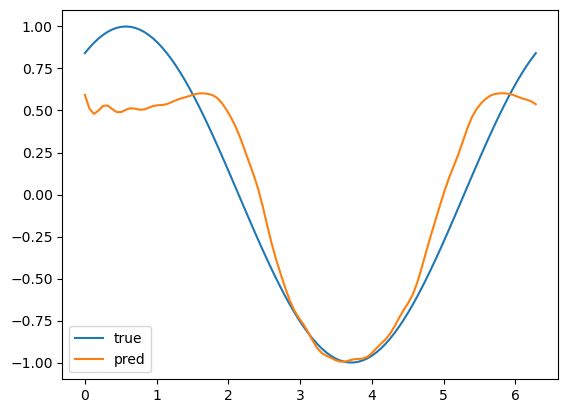

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = S4D(d_model=1, d_state=64, dropout=0.0).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

def f(x):
    return torch.sin(x)

batch_size = 32
seq_len = 100
steps = 2000

for _ in range(steps):
    phi = torch.rand(batch_size, device=device) * 2 * math.pi
    t = torch.linspace(0, 2*math.pi, seq_len, device=device)
    x = f(t.unsqueeze(0) + phi.unsqueeze(1)).unsqueeze(1)
    y = f(t.unsqueeze(0) + phi.unsqueeze(1)).unsqueeze(1)
    pred, _ = model(x)
    loss = loss_fn(pred, y)
    print(loss)
    opt.zero_grad()
    loss.backward()
    opt.step()

model.eval()
phi_test = 1.0
t = torch.linspace(0, 2*math.pi, seq_len)
x_test = f(t + phi_test).unsqueeze(0).unsqueeze(0).to(device)
y_true = f(t + phi_test)
with torch.no_grad():
    y_pred, _ = model(x_test)
y_pred = y_pred.squeeze().cpu()

plt.plot(t.numpy(), y_true.numpy(), label='true')
plt.plot(t.numpy(), y_pred.numpy(), label='pred')
plt.legend()
plt.show()

S4D is complexity $\mathcal{O}(L \log L)$ where $L$ is the sequence length because this is the complexity of the inverse fast fourier transform used to recover the filter. On the other hand attention is $\mathcal{O}(L^2)$ for a similar task.

S4D approximates a continuous-time state space model. Unlike S4, it is diagonal (D), and the learned parameters are the decay and oscillation of the A matrix in a standard SSM and the readout C of each channel. Then the convolution kernel K's FFT is used to produce the output, along with the inputs to the model.

### c)

In [78]:
import torch
import torch.nn as nn

class Lyra(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.pgc1 = ProjectedGatedConv(features, hidden_dim=16)
        self.pgc2 = ProjectedGatedConv(features, hidden_dim=128)
        self.prenorm = RMSNorm(features)
        self.s4d = S4D(d_model=features, d_state=64, dropout=0.0, transposed=True)

    def forward(self, x):
        x = self.pgc1(x)
        x = self.pgc2(x)
        residual = x
        x = self.prenorm(x)
        x_s4d, _ = self.s4d(x.transpose(1, 2))
        x_s4d = x_s4d.transpose(1, 2)
        return x_s4d + residual


"Lyra comprises two core components: the Projected Gated Convolution (PGC) block[43], followed by a state-space layer with depthwise convolution (S4D). In the standard implementation, which consists of approximately 55,000 parameters, Lyra includes two PGC blocks. The first PGC block operates
with a hidden dimension of 16, while the second uses a hidden dimension of 128. These are followed
by an S4D layer[38], which has a hidden dimension of 64 and is equipped with a residual connection
and sequence prenormalization using Root Mean Square Layer Normalization (RMSNorm). The
PGC blocks are designed to capture contextualized local dependencies in the input sequence, while the
S4D layer parameterizes a long convolution to model long-range dependencies."

https://arxiv.org/pdf/2503.16351

### d)

In [79]:
class LyraMini(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.pgc1 = ProjectedGatedConv(features, hidden_dim=8)
        self.pgc2 = ProjectedGatedConv(features, hidden_dim=16)
        self.prenorm = RMSNorm(features)
        self.s4d = S4D(d_model=features, d_state=16, dropout=0.0, transposed=True)

    def forward(self, x):
        x = self.pgc1(x)
        x = self.pgc2(x)
        residual = x
        x = self.prenorm(x)
        x_s4d, _ = self.s4d(x.transpose(1, 2))
        x_s4d = x_s4d.transpose(1, 2)
        return x_s4d + residual


tensor(1.6084, grad_fn=<MseLossBackward0>)
tensor(1.5591, grad_fn=<MseLossBackward0>)
tensor(1.5148, grad_fn=<MseLossBackward0>)
tensor(1.4459, grad_fn=<MseLossBackward0>)
tensor(1.3574, grad_fn=<MseLossBackward0>)
tensor(1.3569, grad_fn=<MseLossBackward0>)
tensor(1.2198, grad_fn=<MseLossBackward0>)
tensor(1.1737, grad_fn=<MseLossBackward0>)
tensor(1.1646, grad_fn=<MseLossBackward0>)
tensor(1.1464, grad_fn=<MseLossBackward0>)
tensor(1.0768, grad_fn=<MseLossBackward0>)
tensor(1.0378, grad_fn=<MseLossBackward0>)
tensor(1.0625, grad_fn=<MseLossBackward0>)
tensor(0.9224, grad_fn=<MseLossBackward0>)
tensor(0.9412, grad_fn=<MseLossBackward0>)
tensor(0.9190, grad_fn=<MseLossBackward0>)
tensor(0.8634, grad_fn=<MseLossBackward0>)
tensor(0.8424, grad_fn=<MseLossBackward0>)
tensor(0.7731, grad_fn=<MseLossBackward0>)
tensor(0.7746, grad_fn=<MseLossBackward0>)
tensor(0.7095, grad_fn=<MseLossBackward0>)
tensor(0.7099, grad_fn=<MseLossBackward0>)
tensor(0.6905, grad_fn=<MseLossBackward0>)
tensor(0.63

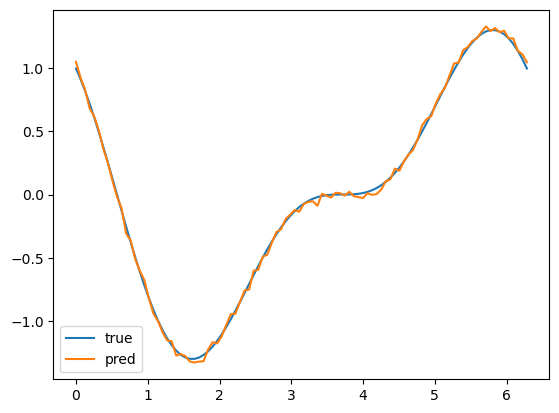

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LyraMini(features=100)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

def f2(x):
    return torch.cos(x) + .5*torch.sin(2*x)

batch_size = 32
seq_len = 100
steps = 300

for _ in range(steps):
    phi = torch.rand(batch_size, device=device) * 2 * math.pi
    t = torch.linspace(0, 2*math.pi, seq_len, device=device)
    x = f2(t.unsqueeze(0) + phi.unsqueeze(1)).unsqueeze(1)
    y = f2(t.unsqueeze(0) + phi.unsqueeze(1)).unsqueeze(1)
    pred = model(x)
    loss = loss_fn(pred, y)
    print(loss)
    opt.zero_grad()
    loss.backward()
    opt.step()

model.eval()
phi_test = 1.0
t = torch.linspace(0, 2*math.pi, seq_len)
x_test = f2(t + phi_test).unsqueeze(0).unsqueeze(0).to(device)
y_true = f2(t + phi_test)
with torch.no_grad():
    y_pred = model(x_test)
y_pred = y_pred.squeeze().cpu()

plt.plot(t.numpy(), y_true.numpy(), label='true')
plt.plot(t.numpy(), y_pred.numpy(), label='pred')
plt.legend()
plt.show()